<a href="https://colab.research.google.com/github/MMRES-PyBootcamp/MMRES-python-bootcamp2023/blob/main/Bayesian/Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import gaussian_kde
from scipy.stats import norm, binom
from matplotlib import rc
rc('font',**{'size':15,'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

# Exercise: Monte-Carlo Markov Chains (MH and Gibbs algorithms)

In this exercise we will work on sampling probability distributions, using both Metropolis-Hastings and Gibbs algorithms. We will be sampling 2D Gaussians with different sigmas and correlation coefficients.  

### Let's define the function and parameters

In [ ]:
NC, NB = 10**6, 10**5                # of MC samples, burn-in period
m1, m2 = 2., 1.                      # means of 2D Gaussian
s1, s2, rho = 1., 2., 0.8        # sigmas and corr. coeff.

In [ ]:
def TwoDGauss(d1, d2):               # Compute un-normalized 2D Gaussian pdf
    return np.exp(-0.5/(1.-rho**2) * ((d1-m1)**2/s1**2 + (d2-m2)**2/s2**2
                                      - 2.*rho*(d1-m1)*(d2-m2)/s1/s2))

In [ ]:
# Making my own color map (you don't need to do this!)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white','ivory',"lightskyblue",'darkslategrey'])

### Now let's plot the 2D Gaussian

In [ ]:
x1_min, x1_max = m1-2*s1, m1+2*s1
x2_min, x2_max = m2-2*s2, m2+2*s2

x1, x2 = np.meshgrid(np.arange(x1_min,x1_max, 0.01), np.arange(x2_min,x2_max, 0.01))
Y = TwoDGauss(x1,x2)

Text(0.5, 1.0, '2D Gaussian')

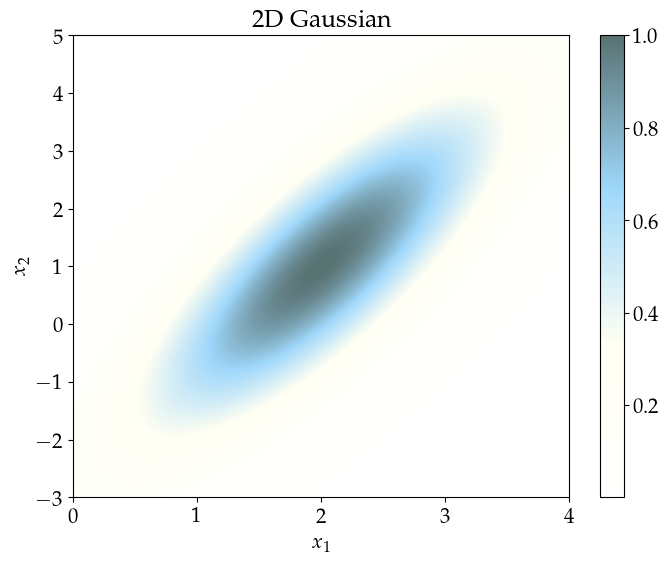

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(Y,extent=[x1_min,x1_max,x2_min,x2_max], cmap=cmap, origin='lower', alpha=0.8, aspect='auto')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'2D Gaussian')

## Sampling with Metropolis-Hastings

Step-by-step description of the Metropolis algorithm:

- **Initialization**: Start with an initial parameter value, denoted as \(\theta_0\), which can be randomly chosen or set based on prior knowledge.


- **Proposal**: Propose a new parameter value, $\theta_{\text{prop}}$, by perturbing the current parameter value $\theta_c$ (in the case of the first iteration $\theta_c = \theta_0$). This perturbation is typically done using a proposal distribution, denoted as $q(\theta_{\text{prop}} | \theta_c)$, which describes how the new parameter value is generated from the current one. Common choices for $q$ include a Gaussian distribution centered at $\theta_c$ or a uniform distribution within a certain range.


- **Acceptance Probability**: Calculate the acceptance probability, denoted as $A(\theta_{\text{prop}}, \theta_c)$, which determines whether to accept or reject the newly proposed parameter. The acceptance probability is  calculated as:

$A(\theta_{\text{prop}}, \theta_c) = \min\left(1, \frac{P(\theta_{\text{prop}}) \cdot q(\theta_c | \theta_{\text{prop}})}{P(x_c) \cdot q(\theta_{\text{prop}} | x_\theta)}\right) $


where: $P(\theta_{\text{prop}})$ is the probability density of the target distribution at the proposed parameter value, $P(\theta_c)$ is the probability density of the target distribution at the current parameter value, and $q(\theta_{\text{prop}} | \theta_c)$ is the proposal density, representing the probability of proposing $\theta_{\text{prop}}$ given $\theta_c$. Note that this acceptance probability does not assume the proposal distribution to be symmetrical. In the case of symmetry for the proposal distribution, $q(\theta_c | \theta_{\text{prop}}) = q(\theta_{\text{prop}}|\theta_c )$, then the expression for the acceptance simplifies and the method is called simply the Metropolis algorithm.

- **Accept or Reject**: Generate a random number $u$ from a uniform distribution between 0 and 1. If $u \leq A(\theta_{\text{prop}}, \theta_c)$, accept the proposed parameter value $(\theta_{c+1} = \theta_{\text{prop}})$; otherwise, reject it $(\theta_{c+1} = \theta_c$ and hence the chain does not move).

- **Iteration**: Repeat steps 2-4 for a predetermined number of iterations or until convergence is achieved. The resulting sequence of states $\theta_0, \theta_1, \theta_2, \ldots$ forms the Markov chain.

- **Output**: The Markov chain, after a burn-in period to allow it to reach a stationary state, is used to obtain samples from the target distribution. These samples can be used for estimating posterior probabilities, generating credible intervals, and performing various Bayesian analyses.


In [ ]:
# We need to define a proposal distribution. We use a 2D uncorrelated Gaussian, with the same sigmas as the original Gaussian. Nota that it is symmetrical.
prop_width = 1.0
def Proposal(d1, d2):
    p1 = np.random.normal(d1, prop_width*s1)
    p2 = np.random.normal(d2, prop_width*s2)
    return p1, p2

In [ ]:
# Sampling

chain = np.zeros((NC, 3))            # Initialize the chain, including pdf
#x1_0, x2_0 = 0., 0.                  # We can play with this
x1_0, x2_0 = 20., 20.                  # We can play with this
chain[0] = x1_0, x2_0, TwoDGauss(x1_0, x2_0)
count_accepted = 0                   # This is to keep track of how many accepted proposals we have

for i in range(NC-1):                         # Fill the chain with MH sampling
    xstar1, xstar2 = Proposal(chain[i,0], chain[i,1])
    pdfStar = TwoDGauss(xstar1, xstar2)
    ratio =  pdfStar / chain[i,2]
    if ratio >= 1:                            # Acceptance check
        chain[i+1] = xstar1, xstar2, pdfStar
        count_accepted += 1
    elif ratio > np.random.random():
        chain[i+1] = xstar1, xstar2, pdfStar
        count_accepted += 1
    else:
        chain[i+1] = chain[i]

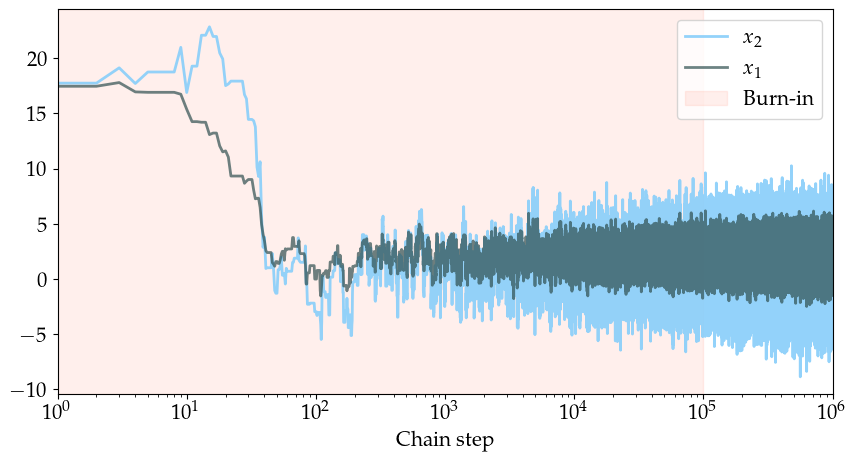

In [ ]:
# Plot each dimension of the chain
plt.figure(figsize=(10,5))
plt.plot(chain[:,1],color='lightskyblue',lw=2,alpha=0.9,label=r'$x_2$')
plt.plot(chain[:,0],color='darkslategrey',lw=2,alpha=0.7,label=r'$x_1$')
plt.xlabel(r'Chain step')
plt.xlim(1,1000000)
plt.axvspan(0,NB,color='tomato',alpha=0.1, label='Burn-in')
plt.legend(frameon=True)
plt.xscale('log')

### Remove burn-in

In [ ]:
chain = chain[NB:]                            # Burn-in
x1, x2 = chain[:,0], chain[:,1]

### Now some statistics

In [ ]:
# Efficiency of the chain (we don't want this to be too low, will depend on the proposal)
print(count_accepted/float(NC))

0.401885


In [ ]:
# Do we recover the input parameters of our 2dGaussian?
print(m1, m2, x1.mean(), x2.mean())
print(s1, s2, x1.std(ddof=1), x2.std(ddof=1))
print(rho, np.corrcoef(x1, x2)[0,1])

2.0 1.0 2.004835232568989 1.0084265138410482
1.0 2.0 0.9984070751738079 1.9929852780662836
0.8 0.7993446721144053


### Plotting the chain

Text(0.5, 1.0, 'Sampling of 2D Gaussian')

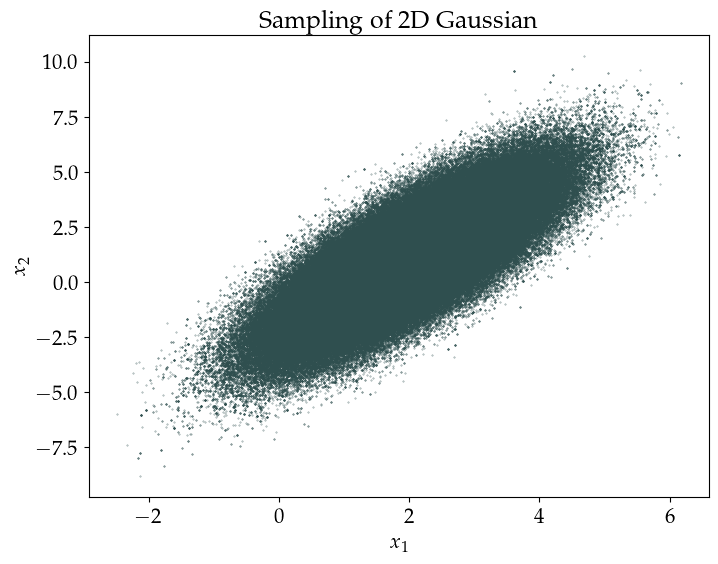

In [ ]:
# First a simple scatter plot
plt.figure(figsize=(8,6))
plt.scatter(x1, x2,0.1,color='darkslategrey',alpha=0.7)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Sampling of 2D Gaussian')

Text(0.5, 1.0, 'Sampling of 2D Gaussian')

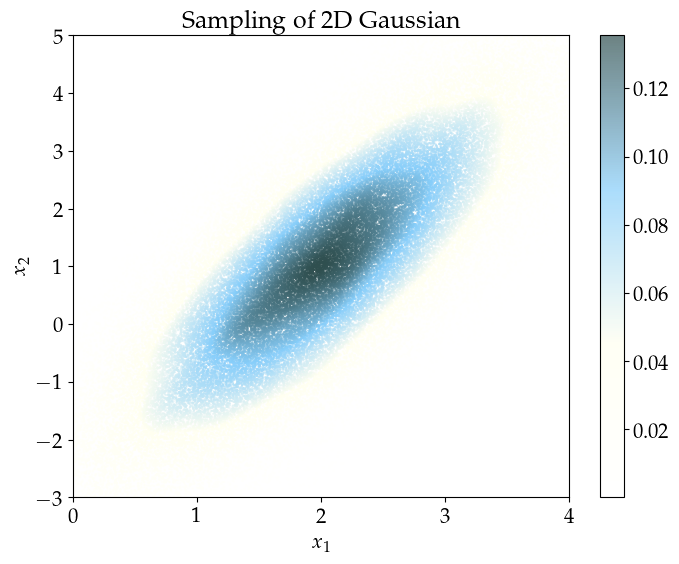

In [ ]:
# And also colored by density (we need to downsample for the KDE)
mask = np.random.rand(len(x1))<0.1
xy = np.vstack([x1[mask],x2[mask]])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x, y, z = x1[mask][idx], x2[mask][idx], z[idx]

# First a simple scatter plot
plt.figure(figsize=(8,6))
plt.scatter(x, y, 0.2, c=z, alpha=0.7, cmap=cmap)
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim(x1_min,x1_max)
plt.ylim(x2_min,x2_max)
plt.title(r'Sampling of 2D Gaussian')

Text(0.5, 1.0, '2D Gaussian')

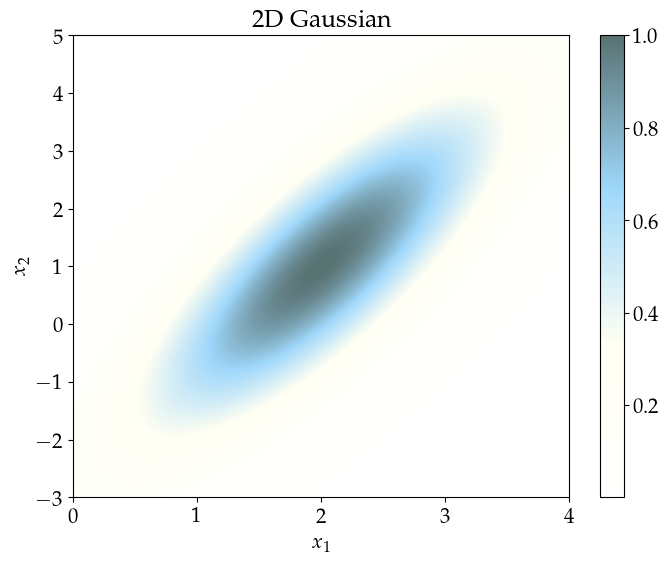

In [ ]:
# Which can be compared to our original plot
plt.figure(figsize=(8,6))
plt.imshow(Y,extent=[x1_min,x1_max,x2_min,x2_max], cmap=cmap, origin='lower', alpha=0.8, aspect='auto')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'2D Gaussian')

### Play with:
- Initial point in the chain.
- Width of the proposal distribution.
- Correlation factor of the 2D Gaussian, to see how acceptance rate (efficiency) changes.